In [172]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM,  ScoreCAM, HiResCAM, EigenCAM, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

from dataset import CUBDataset, FGVCAircraft, FOODDataset
from torchvision.transforms import v2
from torch.utils.data import ConcatDataset 
import torch
from torch.utils.data import default_collate

from matplotlib import pyplot as plt


from models.model import get_model
from utils import load_model

In [2]:
transforms_test = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224), antialias=True),
        v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    ])

dataset_path = "datasets/CUB/CUB_200_2011"


test_dataset = CUBDataset(image_root_path=dataset_path, transform=transforms_test, split="test")

class_names = test_dataset.classes

In [3]:
image, label = test_dataset[1]
print("Image Shape:", image.shape)

Image Shape: torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


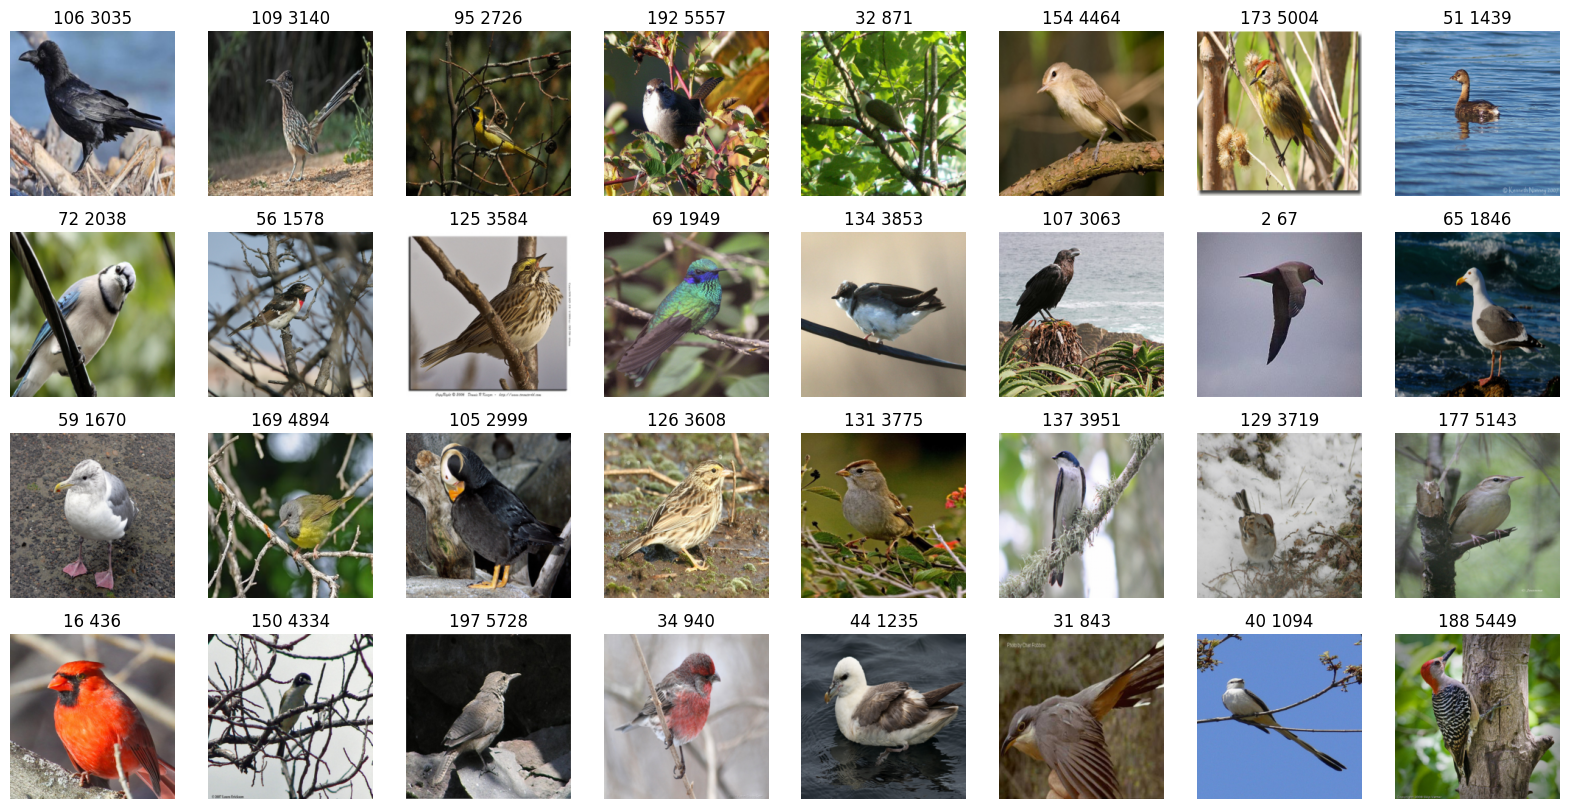

In [184]:
# show some images
# random select 32 images
# np.random.seed(0)
indices = np.random.randint(0, len(test_dataset), size=32)

fig, axes = plt.subplots(4, 8, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    image, label = test_dataset[indices[i]]
    image = image.permute(1, 2, 0)
    # remove normalization
    image = image * torch.tensor([0.229,0.224,0.225]) + torch.tensor([0.485,0.456,0.406])
    ax.imshow(image)

    # label = label.item()
    # label = class_names[label]
    label = str(label) + " " + str(indices[i])
    ax.set_title(label)
    ax.axis('off')
plt.show()

In [166]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset_name = "CUB"

model_name_1 = "ConvNeXtBase"
model_name_2 = "ConvTransNeXtBase"

model_1 = get_model(model_name_1, pretrained=True, num_classes=200)
model_2 = get_model(model_name_2, pretrained=True, num_classes=200)

run_name_1 = "2024-01-24_10-19-34"
run_name_2 = "2024-01-24_09-49-58"

weights_path_1 = f"runs_hpc/runs/{dataset_name}/{model_name_1}/{run_name_1}/best_model.pth"
weights_path_2 = f"runs/{dataset_name}/{model_name_2}/{run_name_2}/best_model.pth"

model_1 = load_model(model_1, weights_path_1)
model_2 = load_model(model_2, weights_path_2)
model_2.eval();

In [188]:
idx = 5449

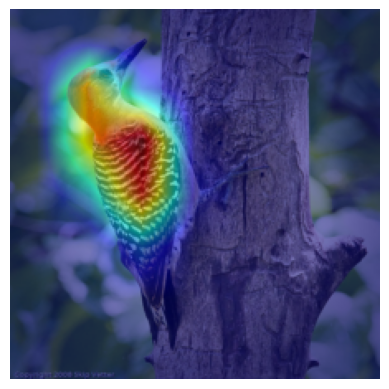

In [196]:
def reshape_transform(tensor, height=14, width=14):
    # result = tensor[:, 1 :  , :].reshape(tensor.size(0),
    #     height, width, tensor.size(2))

    # # Bring the channels to the first dimension,
    # # like in CNNs.
    # result = result.transpose(2, 3).transpose(1, 2)
    result = tensor
    print(result.shape)
    Exception("stop")
    return result

image, label = test_dataset[idx]
img = image.permute(1, 2, 0).numpy()
img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
img = np.clip(img, 0, 1)
image = image.unsqueeze(0)

targets = [ClassifierOutputTarget(label)]
target_layers = [model_1.features[-1], model_1.features[-2]]

with EigenCAM(model=model_1, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=image, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

plt.imshow(cam_image)
plt.axis('off');

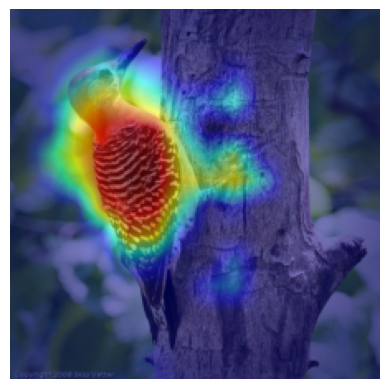

In [195]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor.reshape(height, width, tensor.size(1), tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.permute(2, 3, 0, 1)
    return result

image, label = test_dataset[idx]
img = image.permute(1, 2, 0).numpy()
img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
img = np.clip(img, 0, 1)
image = image.unsqueeze(0)

targets = [ClassifierOutputTarget(label)]
target_layers = [
    model_2.transformer_encoder.layers[-1].norm1, model_2.transformer_encoder.layers[-1].norm2,
    model_2.transformer_encoder.layers[-2].norm1, model_2.transformer_encoder.layers[-2].norm2,
    model_2.transformer_encoder.layers[-3].norm1, model_2.transformer_encoder.layers[-3].norm2,
]

with EigenCAM(model=model_2, target_layers=target_layers, reshape_transform=reshape_transform) as cam:
    grayscale_cams = cam(input_tensor=image, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

plt.imshow(cam_image)
plt.axis('off');

# plt.imshow(img)